In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

from CASutils import averaging_utils as avg
from CASutils import qbo_utils as qbo
from CASutils import plotposition_utils as plotpos
from CASutils import readdata_utils as read
from CASutils import colorbar_utils as cbars
from CASutils import filter_utils as filt
from CASutils import plothisto_utils as histo

import sys

In [2]:
plotpath="/project/cas/islas/python_plots/CAM7_vertres_paper/FIGURES/SUPP/"

### Composites of the transitions from easterly to westerly at each level using 30 day running means of zonal mean zonal wind

In [3]:
def maketransitioncomposites(dat, nlag):
    
    #---composite code
    def dothecomposite(dat, ewloc, nlag):
        #lagarr = np.arange(-nlag,nlag+1,1)
        lagarr = np.arange(-nlag,0)
        for icomp in np.arange(0,len(ewloc),1):
            #datuse = dat.isel(time=slice( int(ewloc[icomp]-nlag), int(ewloc[icomp]) + nlag + 1))
            datuse = dat.isel(time=slice( int(ewloc[icomp]-nlag),int(ewloc[icomp])))
            datuse['time'] = lagarr
            if (icomp == 0):
                datcomp = datuse / len(ewloc)
            else:
                datcomp = datcomp + datuse / len(ewloc)
        return datcomp
    #---end composite code
    
    comp_u = []
    comp_divf = [] 
    comp_fz = []
    
    for pplot in np.arange(0,dat.ilev.size,1):
        uzm = dat.uzm.isel(ilev=pplot)
        u30d = filt.runningmean(uzm, 30, dropna=False)
        ewloc, weloc = qbo.finde2w(u30d)
        ewloc = ewloc[ (ewloc > nlag) & (ewloc < (dat.time.size - nlag)) ]
        
        comp_u_t = dothecomposite(dat.uzm.isel(ilev=pplot), ewloc, nlag)
        comp_divf_t = dothecomposite(dat.utendepfd.isel(ilev=pplot), ewloc, nlag)
        comp_fz_t = dothecomposite(dat.epfz.isel(ilev=pplot), ewloc, nlag)
        
        comp_u_t = comp_u_t.rename('uzm')
        comp_divf_t = comp_divf_t.rename('divf')
        comp_fz_t = comp_fz_t.rename('fz')
        
        comp_u.append(comp_u_t)
        comp_divf.append(comp_divf_t)
        comp_fz.append(comp_fz_t)
        
        
    comp_u = xr.concat(comp_u, dim='ilev')
    comp_divf = xr.concat(comp_divf, dim='ilev')
    comp_fz = xr.concat(comp_fz, dim='ilev')
    
    comp_u['ilev'] = dat.ilev
    comp_divf['ilev'] = dat.ilev
    comp_fz['ilev'] = dat.ilev
    
    datout = xr.merge([comp_u, comp_divf, comp_fz])
    return datout

In [4]:
nlags=90
w=5
era5 = xr.open_dataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/TEMdiags/day/ERA5.nc")
era5 = era5.rename(plev='ilev')
era5['ilev'] = era5.ilev/100.
era5 = era5.where( (era5.ilev < 110) & (era5.ilev > 7), drop=True)
era5_tr = avg.cosweightlat(era5, -1.*w, w)

era5_composite = maketransitioncomposites(era5_tr, nlags)

dz=['800','700','600','500']
alldat=[]
for i in np.arange(0,len(dz),1):
    basepath="/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/TEMdiags/day/"
    dat = xr.open_dataset(basepath+'dz'+dz[i]+'_80km.nc')
    
    dat_tr = avg.cosweightlat(dat, -1*w, w)
    dat_tr = dat_tr.where((dat_tr.ilev < 110) & (dat_tr.ilev > 7), drop=True)
    
    datout = maketransitioncomposites(dat_tr, nlags)
    
    alldat.append(datout)

DatasetWeighted with weights along dimensions: lat
DatasetWeighted with weights along dimensions: lat
DatasetWeighted with weights along dimensions: lat
DatasetWeighted with weights along dimensions: lat
DatasetWeighted with weights along dimensions: lat


In [ ]:
#dz=['800','700','600','500']
#alldat_decomp=[]
#basepath="/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/QBOcomposites/90day_beforeW/"
#for i in np.arange(0,len(dz),1):
#    dat = xr.open_dataset(basepath+'QBOcomposite_dz'+str(dz[i])+'_90days_50_80km.nc')
#    dat = dat.mean('time')
#    alldat_decomp.append(dat)
#alldat_decomp = xr.concat(alldat_decomp, dim=dz)

#era5_decomp = xr.open_dataset(
#              "/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/QBOcomposites/90day_beforeW/QBOcomposite_ERA5_90days_50.nc")

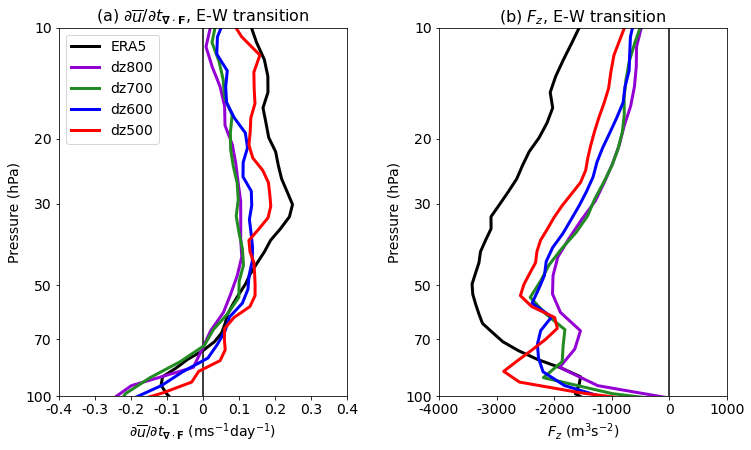

In [6]:
fig = plt.figure(figsize=(16,16))

colors=['darkviolet','forestgreen','blue','red']

ax = fig.add_axes([0.05,0.32,0.25,0.32])
ax.set_ylim(-np.log10(100),-np.log10(10))
ax.set_yticks([-np.log10(100),-np.log10(70),-np.log10(50),-np.log10(30),-np.log10(20),-np.log10(10)])
ax.set_yticklabels(['100','70','50','30','20','10'], fontsize=14)
ax.set_ylabel('Pressure (hPa)', fontsize=14)
ax.set_xlim(-0.4,0.4)
ax.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])
ax.set_xticklabels(['-0.4','-0.3','-0.2','-0.1','0','0.1','0.2','0.3','0.4'], fontsize=14)
ax.set_xlabel(r'$\partial\overline{u}/\partial t_{\mathbf{\nabla}\cdot\mathbf{F}}$ (ms$^{-1}$day$^{-1}$)', fontsize=14)
ax.set_title(r'(a) $\partial\overline{u}/\partial t_{\mathbf{\nabla}\cdot\mathbf{F}}$, E-W transition', fontsize=16)

ax.plot([0,0],[-np.log10(100),-np.log10(10)], color='black')

ax.plot(86400.*era5_composite.divf.mean('time'),-1.*np.log10(era5_composite.ilev), color='black', linewidth=3, label='ERA5')
for i in np.arange(0,len(dz),1):
    dat = alldat[i]
    ax.plot(86400.*dat.divf.mean('time'),-1.*np.log10(dat.ilev), color=colors[i], linewidth=3, label='dz'+dz[i])

ax.legend(fontsize="14")



ax = fig.add_axes([0.38,0.32,0.25,0.32])
ax.set_ylim(-np.log10(100),-np.log10(10))
ax.set_yticks([-np.log10(100),-np.log10(70),-np.log10(50),-np.log10(30),-np.log10(20),-np.log10(10)])
ax.set_yticklabels(['100','70','50','30','20','10'], fontsize=14)
ax.set_ylabel('Pressure (hPa)', fontsize=14)
ax.set_xlim(-4000,1000)
ax.set_xticks([-4000,-3000,-2000,-1000,0,1000])
ax.set_xticklabels(['-4000','-3000','-2000','-1000','0','1000'], fontsize=14)
ax.set_xlabel('$F_{z}$ (m$^{3}$s$^{-2}$)', fontsize=14)
ax.set_title('(b) $F_{z}$, E-W transition', fontsize=16)

ax.plot([0,0],[-np.log10(100),-np.log10(10)], color='black')
ax.plot(era5_composite.fz.mean('time'),-1.*np.log10(era5_composite.ilev), color='black', linewidth=3)
for i in np.arange(0,len(dz),1):
    dat = alldat[i]
    ax.plot(dat.fz.mean('time'),-1.*np.log10(dat.ilev), color=colors[i], linewidth=3)


fig.savefig(plotpath+'figS6.pdf', bbox_inches='tight', facecolor='white')